Generacja V02 histogramy kolorów RG - kod wstępnie uporząkowany; liczba ekspertów = 4

In [ ]:
!pip install medmnist

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from medmnist import INFO, BloodMNIST
import numpy as np
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import jensenshannon
import torch.nn.functional as F

In [2]:
# Wczytanie danych do generacji i klasyfikacji

# Współczynniki 
isize = 128 # możliwe warianty dostępne w bazie: 64 128 224
batch_size = 64
num_images = 1000
NUM_CLASSES = 8
num_epochs = 100 # Ma być 100
num_experts = 4

# Transformacje danych
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5])  # Normalizacja do [-1, 1]
])

# Ładowanie danych BloodMNIST
train_dataset = BloodMNIST(split='train', transform=data_transforms, download=True, as_rgb=True, size=isize)
val_dataset = BloodMNIST(split='val', transform=data_transforms, download=True, as_rgb=True, size=isize)
test_dataset = BloodMNIST(split='test', transform=data_transforms, download=True, as_rgb=True, size=isize)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Tworzenie etykiet klas (wersja skrócona)
info = INFO['bloodmnist']
class_labels = info['label']
legend_labels = [f"{value[:20]}" for key, value in class_labels.items()]

Using downloaded and verified file: /root/.medmnist/bloodmnist_128.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist_128.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist_128.npz


In [ ]:
# Tylko test
# Tworzenie DataLoaderów
train_loader = DataLoader(
    train_dataset,
    batch_size,  # Zwiększaj do maksymalnego możliwego 128
    shuffle=True,
    num_workers=4,  # 4-8 
    pin_memory=False,  
    persistent_workers=True,  
    prefetch_factor=2  
)

val_loader = DataLoader(
    val_dataset,
    batch_size=256,  # Większy batch dla walidacji
    num_workers=4,
    pin_memory=False
)

[Epoch 0/100] [Batch 0/187] Accuracy adv: 0.60 Accuracy G: 0.17 [D loss: 1.72] [G loss: 8.16] [Loss adv: 0.66] [Class loss: 2.08] [Hist loss: 0.3339]
[Epoch 0/100] [Batch 100/187] Accuracy adv: 0.67 Accuracy G: 1.00 [D loss: 1.01] [G loss: 1.86] [Loss adv: 0.76] [Class loss: 0.11] [Hist loss: 0.0886]
[Epoch 1/100] [Batch 0/187] Accuracy adv: 0.66 Accuracy G: 1.00 [D loss: 0.96] [G loss: 1.73] [Loss adv: 0.78] [Class loss: 0.07] [Hist loss: 0.0815]
[Epoch 1/100] [Batch 100/187] Accuracy adv: 0.62 Accuracy G: 1.00 [D loss: 0.90] [G loss: 1.79] [Loss adv: 0.89] [Class loss: 0.04] [Hist loss: 0.0825]
[Epoch 2/100] [Batch 0/187] Accuracy adv: 0.59 Accuracy G: 1.00 [D loss: 0.92] [G loss: 1.54] [Loss adv: 0.81] [Class loss: 0.02] [Hist loss: 0.0684]
[Epoch 2/100] [Batch 100/187] Accuracy adv: 0.68 Accuracy G: 1.00 [D loss: 0.82] [G loss: 1.41] [Loss adv: 0.79] [Class loss: 0.02] [Hist loss: 0.0582]
[Epoch 3/100] [Batch 0/187] Accuracy adv: 0.58 Accuracy G: 1.00 [D loss: 0.82] [G loss: 2.05] 

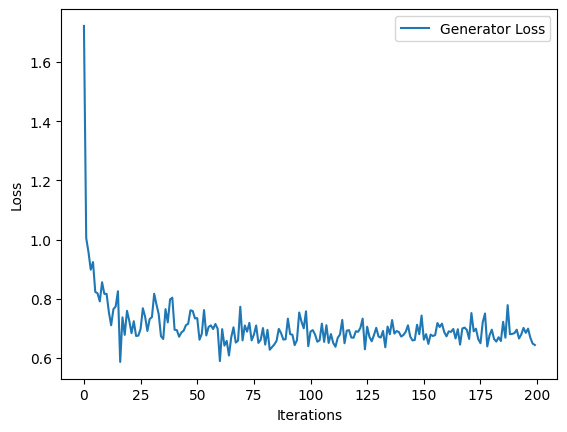

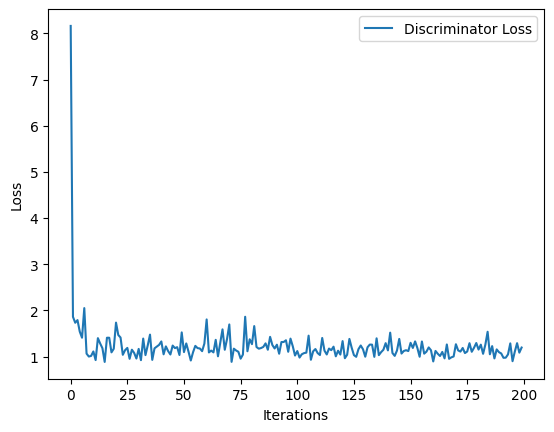

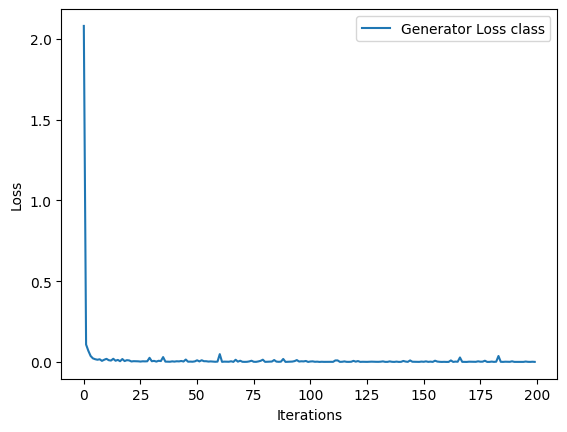

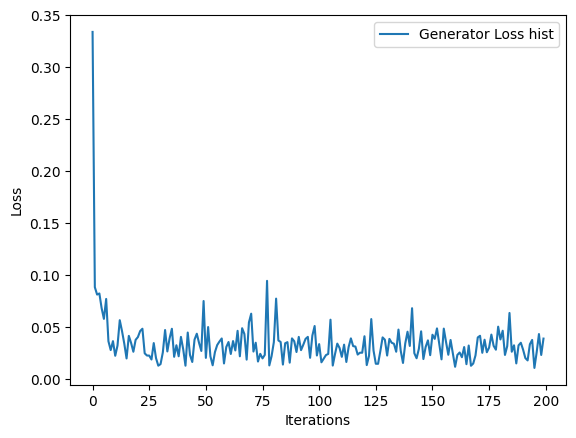

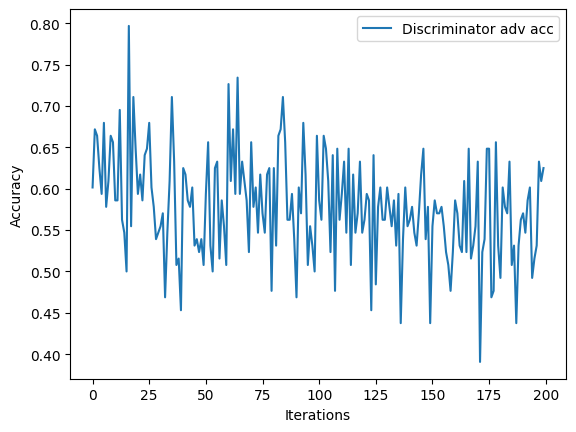

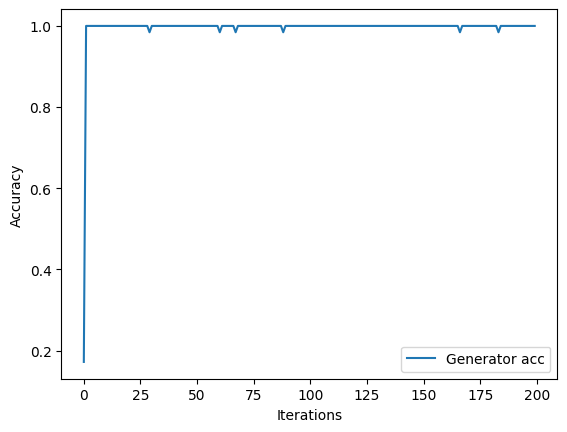

Wygenerowano 1000 nowych obrazów


In [3]:
# Główny blok ############################################################################

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)


# Definiowanie Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.instance_norm1 = nn.InstanceNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.instance_norm2 = nn.InstanceNorm2d(in_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.instance_norm1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.instance_norm2(out)
        out += residual
        return out

# Definiowanie Generatora z Mixture of Experts
class Generator(nn.Module):
    def __init__(self, num_experts, latent_dim=100):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = NUM_CLASSES
        self.image_size = isize
        self.num_experts = num_experts

        # Embedding dla etykiet
        self.label_embedding = nn.Embedding(NUM_CLASSES, NUM_CLASSES)

        self.init_size = isize // 4  # Rozdzielczość początkowa (zmniejszona o 4x)

        # Gating Network
        self.gating_network = nn.Sequential(
            nn.Linear(latent_dim + NUM_CLASSES, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_experts),
            nn.Softmax(dim=1)
        )

        # Eksperci
        self.experts = nn.ModuleList([
            self._create_expert() for _ in range(num_experts)
        ])

        # Inicjalizacja rozmiaru
        self.init_size = isize // 4

    def _create_expert(self):
        return nn.Sequential(
            nn.Linear(self.latent_dim + NUM_CLASSES, 128 * self.init_size * self.init_size),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Unflatten(1, (128, self.init_size, self.init_size)),
            nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            ResidualBlock(128),
            ResidualBlock(128),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Wbudowanie etykiet i połączenie z wektorem latentnym
        labels_embedded = self.label_embedding(labels)
        x = torch.cat((noise, labels_embedded), dim=1)

        # Gating Network wybiera eksperta
        gate_outputs = self.gating_network(x)  # (batch_size, num_experts)
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)  # (batch_size, num_experts, C, H, W)

        # Ważona suma wyników ekspertów
        gate_outputs = gate_outputs.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)  # (batch_size, num_experts, 1, 1, 1)
        img = (expert_outputs * gate_outputs).sum(dim=1)  # (batch_size, C, H, W)

        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.image_size = isize
        self.num_classes = NUM_CLASSES

        # Bloki konwolucyjne
        self.conv_blocks = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4), # było 0.5 21.01
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3)  # Maksymalnie 3 warstwy konwolucyjne
        )

        # Obliczenie wielkości po przejściu przez bloki konwolucyjne
        ds_size = isize // 2**3  # Zmniejszone ze względu na mniejszą liczbę warstw

        # Blok końcowy
        self.adv = nn.Linear(256 * ds_size * ds_size, 1)  # Brak Sigmoid
        self.clf = nn.Linear(256 * ds_size * ds_size, NUM_CLASSES)  # Wieloklasowy klasyfikator

    def forward(self, x):
        x = self.conv_blocks(x)
        x = x.view(x.size(0), -1)  # Flatten
        validity = self.adv(x)  # Wyjście dyskryminatora, surowe logity (wartości bezpośrednie)
        labels = self.clf(x)    # Wyjście klasyfikatora (class_pred)
        return validity, labels

def wasserstein_histogram_loss_RG(gen_images, real_images, bins=256):  # bez B
    bin_edges = torch.linspace(0, 1, bins + 1, device=gen_images.device)

    def compute_cumulative_histogram(images):
        histograms = []
        for channel in range(images.shape[1] - 1):  # Pomijamy kanał B
            values = images[:, channel, :, :].flatten()
            with torch.no_grad():
                hist = torch.histc(values, bins=bins, min=0, max=1)
            cumulative_hist = torch.cumsum(hist, dim=0) / values.size(0)
            histograms.append(cumulative_hist)
        return histograms

    real_cum_hist = compute_cumulative_histogram(real_images)
    gen_cum_hist = compute_cumulative_histogram(gen_images)

    losses = [
        torch.mean(torch.abs(real_cum_hist[i] - gen_cum_hist[i]))
        for i in range(len(real_cum_hist))
    ]

    return sum(losses)

def wasserstein_histogram_loss_RGB(gen_images, real_images, bins=256):  
    bin_edges = torch.linspace(0, 1, bins + 1, device=gen_images.device)

    def compute_cumulative_histogram(images):
        histograms = []
        for channel in range(images.shape[1] - 1):  # Pomijamy kanał B
            values = images[:, channel, :, :].flatten()
            with torch.no_grad():
                hist = torch.histc(values, bins=bins, min=0, max=1)
            cumulative_hist = torch.cumsum(hist, dim=0) / values.size(0)
            histograms.append(cumulative_hist)
        return histograms

    real_cum_hist = compute_cumulative_histogram(real_images)
    gen_cum_hist = compute_cumulative_histogram(gen_images)

    losses = [
        torch.mean(torch.abs(real_cum_hist[i] - gen_cum_hist[i]))
        for i in range(len(real_cum_hist))
    ]

    return sum(losses)


def train_gan(dataset, dataloader, num_epochs=num_epochs, batch_size=64, latent_dim=100, ):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator = Generator(num_experts, latent_dim).to(device)
    discriminator = Discriminator().to(device)

    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999)) #0.0002
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

    adversarial_loss = nn.BCEWithLogitsLoss()
    classification_loss = nn.CrossEntropyLoss()

    # Lista do zapisywania wartości strat
    g_losses = []
    d_losses = []
    g_losses_class = []
    g_losses_hist = []
    g_acc = []
    adv_acc = []

    for epoch in range(num_epochs):
        for i, (real_images, labels) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            # Konwersja etykiet na właściwy format
            real_labels = labels.squeeze().long().to(device)  # Dodano squeeze() i konwersję na long

            # Etykiety dla GAN
            real_validity = torch.ones(batch_size, 1).to(device)
            fake_validity = torch.zeros(batch_size, 1).to(device)

            # ---------------------
            #  Trening Dyskryminatora
            # ---------------------
            d_optimizer.zero_grad()

            # Prawdziwe obrazy
            real_validity_pred, real_class_pred = discriminator(real_images)
            d_real_loss = (
                adversarial_loss(real_validity_pred, real_validity) +
                classification_loss(real_class_pred, real_labels)
            )

            # Fałszywe obrazy
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_labels = torch.randint(0, NUM_CLASSES, (batch_size,)).to(device)
            generated_images = generator(z, fake_labels)
            fake_validity_pred, fake_class_pred = discriminator(generated_images.detach())
            # Adversarial accuracy: czy dyskryminator poprawnie rozpoznaje real/fake
            # Prawdziwe dane -> 1, Fałszywe dane -> 0
            real_validity_prob = torch.sigmoid(real_validity_pred)
            fake_validity_prob = torch.sigmoid(fake_validity_pred)
            real_validity_correct = (real_validity_prob > 0.5).sum().item()  # Prawdziwe dane jako 1
            fake_validity_correct = (fake_validity_prob <= 0.5).sum().item()  # Fałszywe dane jako 0
            # Liczenie dokładności
            adv_accuracy = (real_validity_correct + fake_validity_correct) / (2 * batch_size)

            d_fake_loss = adversarial_loss(fake_validity_pred, fake_validity)

            # Całkowita strata dyskryminatora
            d_loss = (d_real_loss + d_fake_loss) / 2
            
            d_loss.backward()
            d_optimizer.step()

            # -----------------
            #  Trening Generatora
            # -----------------
            g_optimizer.zero_grad()

            fake_validity_pred, fake_class_pred = discriminator(generated_images)
            g_loss_adv = adversarial_loss(fake_validity_pred, real_validity)
            g_loss_class = classification_loss(fake_class_pred, fake_labels)
            
            # Obliczenie dokładności
            predicted_labels = torch.argmax(fake_class_pred, dim=1)  # Indeksy klas o najwyższym prawdopodobieństwie
            correct = (predicted_labels == fake_labels).sum().item()  # Liczba poprawnych predykcji
            g_accuracy = correct / fake_labels.size(0)  # Liczba poprawnych / liczba próbek
 
            g_loss_hist = wasserstein_histogram_loss_RG(generated_images, real_images)
            g_loss = 1.0*g_loss_adv + 2.0*g_loss_class + 10.0*g_loss_hist  # Wagi 
            
            g_loss.backward()
            g_optimizer.step()

            if i % 100 == 0:
                # Zapisanie wartości strat
                d_losses.append(d_loss.item())
                g_losses.append(g_loss.item())
                g_losses_class.append(g_loss_class.item())
                g_losses_hist.append(g_loss_hist.item())
                g_acc.append(g_accuracy)
                adv_acc.append(adv_accuracy)

                print(
                    f"[Epoch {epoch}/{num_epochs}] "
                    f"[Batch {i}/{len(dataloader)}] "
                    f"Accuracy adv: {adv_accuracy:.2f} "
                    f"Accuracy G: {g_accuracy:.2f} "
                    f"[D loss: {d_loss.item():.2f}] "
                    f"[G loss: {g_loss.item():.2f}] "
                    f"[Loss adv: {g_loss_adv.item():.2f}] "
                    f"[Class loss: {g_loss_class.item():.2f}] "
                    f"[Hist loss: {g_loss_hist.item():.4f}]"
                )


    plt.plot(d_losses, label='Generator Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig("Metric01.jpg", dpi=300, bbox_inches='tight')
    plt.show()

    plt.plot(g_losses, label='Discriminator Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig("Metric02.jpg", dpi=300, bbox_inches='tight')
    plt.show()

    plt.plot(g_losses_class, label='Generator Loss class')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig("Metric03.jpg", dpi=300, bbox_inches='tight')
    plt.show()

    plt.plot(g_losses_hist, label='Generator Loss hist')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig("Metric04.jpg", dpi=300, bbox_inches='tight')
    plt.show()

    plt.plot(adv_acc, label='Discriminator adv acc')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig("Metric05.jpg", dpi=300, bbox_inches='tight')
    plt.show()

    plt.plot(g_acc, label='Generator acc')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig("Metric06.jpg", dpi=300, bbox_inches='tight')
    plt.show()

    return generator, discriminator

def generate_images(generator, num_images=num_images, latent_dim=100, specific_class=None):
    device = next(generator.parameters()).device
    z = torch.randn(num_images, latent_dim).to(device)

    if specific_class is None:
        labels = torch.randint(0, NUM_CLASSES, (num_images,)).to(device)
    else:
        labels = torch.full((num_images,), specific_class, dtype=torch.long).to(device) # to sie nie wykonuje

    generator.eval()
    with torch.no_grad():
        generated_images = generator(z, labels)
    generator.train()

    return generated_images, labels

if __name__ == "__main__":
    generator, discriminator = train_gan(train_dataset, train_loader)
    generated_samples, generated_labels = generate_images(generator)
    print(f"Wygenerowano {len(generated_samples)} nowych obrazów")


<ipython-input-4-f1d44d19f0a2>:61: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  labels = torch.tensor(labels)  # Convert labels to a tensor if needed


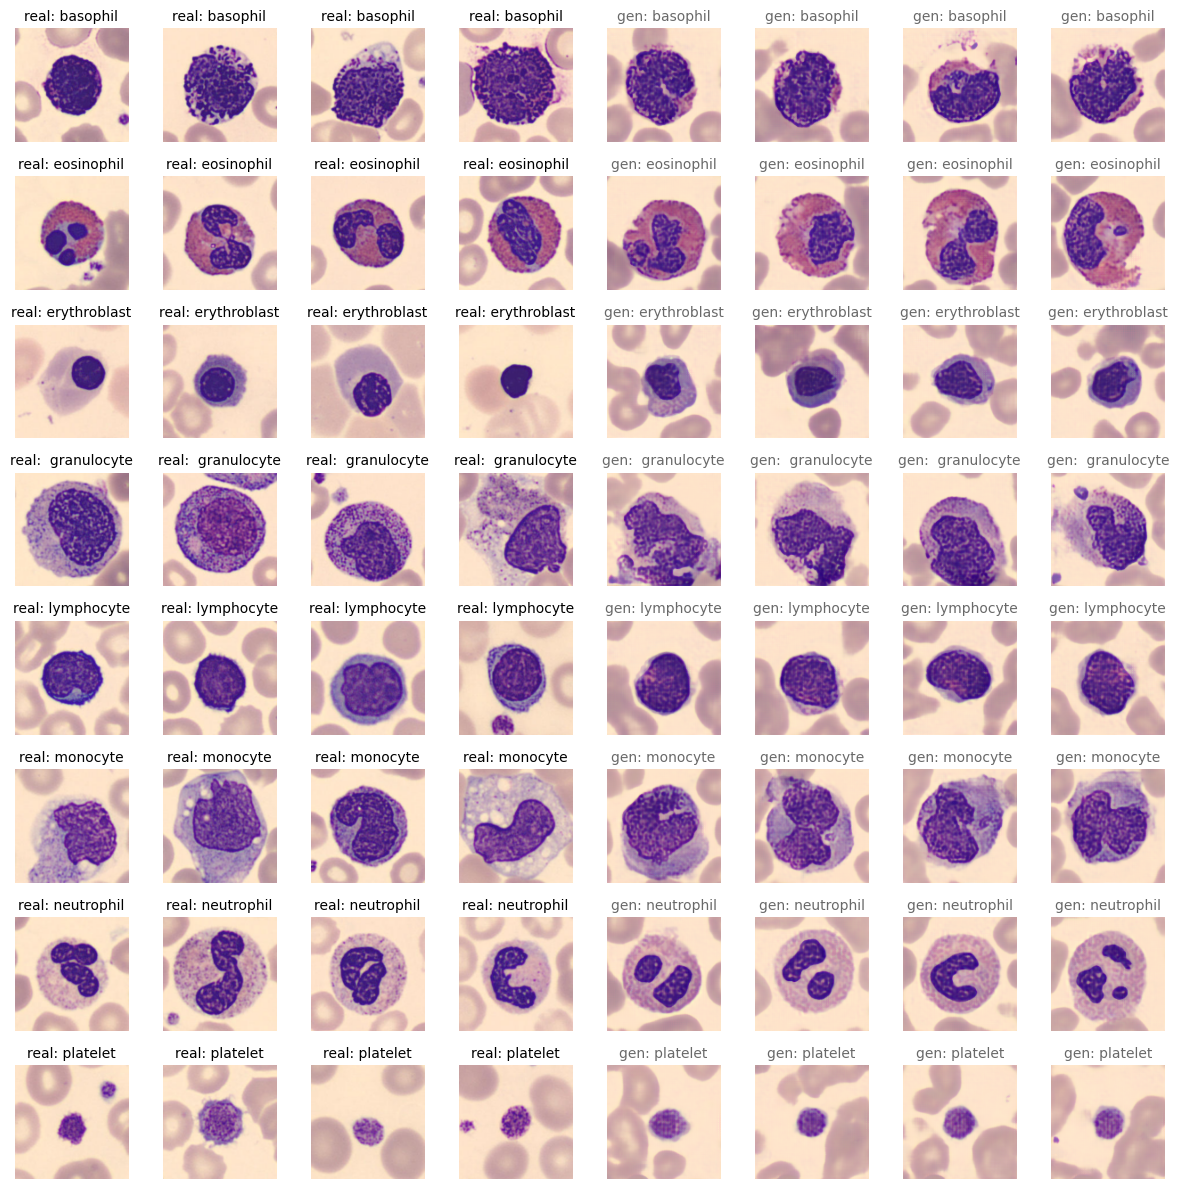

In [4]:
# Nowa wersja
# Funkcja do rysowania obrazów z podziałem na klasy
def compare_classes(real_samples, real_labels, generated_samples, generated_labels, num_images_per_class):
    num_classes = 8
    real_samples = (real_samples + 1) / 2.0
    generated_samples = (generated_samples + 1) / 2.0

    # Inicjalizacja wykresów
    fig, axes = plt.subplots(num_classes, num_images_per_class * 2, figsize=(num_images_per_class * 3, num_classes * 1.5))

    # Iteracja po klasach
    for class_label in range(num_classes):
        # Filtruj próbki dla danej klasy (real)
        real_class_indices = (real_labels == class_label).nonzero(as_tuple=True)[0]
        real_selected_indices = real_class_indices[:num_images_per_class]

        # Filtruj próbki dla danej klasy (generated)
        gen_class_indices = (generated_labels == class_label).nonzero(as_tuple=True)[0]
        gen_selected_indices = gen_class_indices[:num_images_per_class]

        for i, (real_idx, gen_idx) in enumerate(zip(real_selected_indices, gen_selected_indices)):
            # Obrazy rzeczywiste
            ax_real = axes[class_label, i]
            real_image = real_samples[real_idx].detach().cpu().numpy()
            real_image = np.transpose(real_image, (1, 2, 0))
            ax_real.imshow(real_image.squeeze(), cmap='gray' if real_image.shape[-1] == 1 else None)
            ax_real.axis('off')
            ax_real.set_title(f'real: {legend_labels[class_label][-12:]}', fontsize=10)

            # Obrazy generowane
            ax_gen = axes[class_label, i + num_images_per_class]
            gen_image = generated_samples[gen_idx].detach().cpu().numpy()
            gen_image = np.transpose(gen_image, (1, 2, 0))
            ax_gen.imshow(gen_image.squeeze(), cmap='gray' if gen_image.shape[-1] == 1 else None)
            ax_gen.axis('off')
            ax_gen.set_title(f'gen: {legend_labels[class_label][-12:]}', color='#696969', fontsize=10)

        # Ukrycie pustych osi, jeśli mniej obrazów w klasie
        for j in range(len(real_selected_indices), num_images_per_class):
            axes[class_label, j].axis('off')
        for j in range(len(gen_selected_indices), num_images_per_class):
            axes[class_label, j + num_images_per_class].axis('off')

    # Popraw odstępy
    plt.tight_layout()
    plt.savefig("Images01.jpg", dpi=300, bbox_inches='tight')
    plt.show()

# Przygotowanie danych przykładowych (real i generated):
# Tensory:
# - real_labels i generated_labels: tensor o rozmiarze (N,), zawierający etykiety (0-7).
# - real_samples i generated_samples: tensor o rozmiarze (N, C, H, W), zawierający obrazy.
# Poniższy kod zakłada już przygotowane dane (real_samples, real_labels, generated_samples, generated_labels).

# Liczba obrazów na klasę
num_images_per_class = 4

samples = [train_dataset[i] for i in range(200)]
images, labels = zip(*samples)
images = torch.stack(images)  # Stack images if they are tensors
labels = torch.tensor(labels)  # Convert labels to a tensor if needed

# Wywołanie funkcji z danymi
compare_classes(images, labels, generated_samples, generated_labels, num_images_per_class)

In [5]:
# Klasyfikacja - trening dla bazy BloodMNIST
from torchvision import models

# Ustawienia urządzenia
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Parametry
num_classes = 8
learning_rate = 0.001 # Dla klasyfikacji
num_epochs = 10

# Wczytanie modelu ResNet50 z wagami ImageNet
weights = models.ResNet50_Weights.DEFAULT
model = models.resnet50(weights=weights)

# Zastąpienie ostatniej warstwy (fc) w celu dostosowania do liczby klas
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Przeniesienie modelu na GPU
model = model.to(device)

# Funkcja kosztu i optymalizator
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Trenowanie modelu
def train_model(model, train_loader, val_loader, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass i optymalizacja
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        # Obliczenie metryk
        train_acc = correct / len(train_loader.dataset)

        # Walidacja
        val_loss, val_acc = evaluate_model(model, val_loader)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

# Walidacja lub testowanie modelu
def evaluate_model(model, data_loader):
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.squeeze().long().to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / len(data_loader.dataset)
    return avg_loss, accuracy

# Trenowanie modelu
train_model(model, train_loader, val_loader, num_epochs)

# Testowanie modelu
test_loss, test_acc = evaluate_model(model, test_loader)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


Using device: cuda
Epoch [1/10], Train Loss: 0.1906, Train Acc: 0.9375, Val Loss: 0.1590, Val Acc: 0.9474
Epoch [2/10], Train Loss: 0.0681, Train Acc: 0.9769, Val Loss: 0.0627, Val Acc: 0.9790
Epoch [3/10], Train Loss: 0.0566, Train Acc: 0.9819, Val Loss: 0.0869, Val Acc: 0.9690
Epoch [4/10], Train Loss: 0.0434, Train Acc: 0.9855, Val Loss: 0.0936, Val Acc: 0.9679
Epoch [5/10], Train Loss: 0.0412, Train Acc: 0.9865, Val Loss: 0.0519, Val Acc: 0.9807
Epoch [6/10], Train Loss: 0.0289, Train Acc: 0.9899, Val Loss: 0.0974, Val Acc: 0.9714
Epoch [7/10], Train Loss: 0.0213, Train Acc: 0.9935, Val Loss: 0.0514, Val Acc: 0.9807
Epoch [8/10], Train Loss: 0.0067, Train Acc: 0.9976, Val Loss: 0.0471, Val Acc: 0.9860
Epoch [9/10], Train Loss: 0.0216, Train Acc: 0.9936, Val Loss: 0.0823, Val Acc: 0.9772
Epoch [10/10], Train Loss: 0.0250, Train Acc: 0.9919, Val Loss: 0.0487, Val Acc: 0.9854
Test Loss: 0.0691, Test Acc: 0.9795


In [6]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report

# Zakładam, że generated_samples i generated_labels to tensory
generated_samples = generated_samples.to(device)
generated_labels = generated_labels.to(device).long()

# Tworzenie DataLoadera
gener_dataset = TensorDataset(generated_samples, generated_labels)
gener_loader = DataLoader(gener_dataset, batch_size=64, shuffle=False)

def evaluate_model_gener(model, data_loader):
    model.eval()
    total_loss = 0
    correct = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

            # Zbieranie predykcji i prawdziwych etykiet
            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / len(data_loader.dataset)

    # Raport klasyfikacyjny
    report = classification_report(all_labels, all_preds, target_names=[legend_labels[i][-12:] for i in range(8)], zero_division=0)
    return avg_loss, accuracy, report

# Wywołanie funkcji oceny
test_loss, test_acc, classification_report_str = evaluate_model_gener(model, gener_loader)

print(f'Gener Loss: {test_loss:.4f}, Gener Acc: {test_acc:.4f}')
print("\nClassification Report:\n")
print(classification_report_str)

Gener Loss: 0.2554, Gener Acc: 0.9260

Classification Report:

              precision    recall  f1-score   support

    basophil       0.95      0.80      0.87       131
  eosinophil       0.82      1.00      0.90       119
erythroblast       1.00      1.00      1.00       114
 granulocyte       0.78      0.82      0.79       114
  lymphocyte       1.00      0.81      0.89       141
    monocyte       0.88      1.00      0.93       114
  neutrophil       1.00      1.00      1.00       137
    platelet       1.00      1.00      1.00       130

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.92      1000
weighted avg       0.93      0.93      0.93      1000



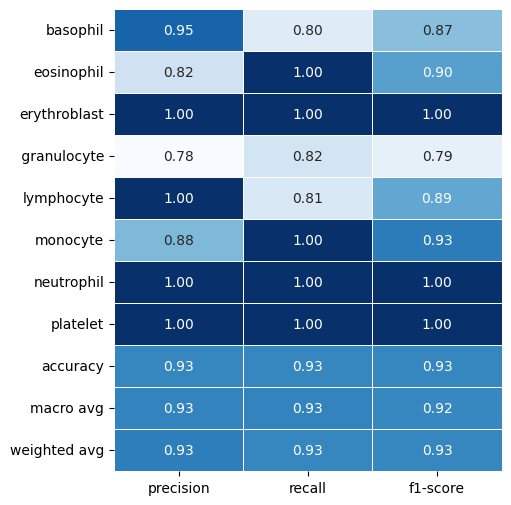

In [7]:
def plot_classification_report(report, title='Classification Report', cmap='Blues'):
    """
    Wyświetla raport klasyfikacyjny jako heatmapę.

    :param report: Raport klasyfikacyjny w formacie słownikowym (z sklearn).
    :param title: Tytuł wykresu.
    :param cmap: Kolorystyka heatmapy.
    """
    # Konwersja raportu do DataFrame
    report_df = pd.DataFrame(report).transpose()
    report_df = report_df.drop(['support'], axis=1)  # Opcjonalne usunięcie kolumny 'support'

    plt.figure(figsize=(5, 6))
    sns.heatmap(report_df, annot=True, fmt=".2f", cmap=cmap, cbar=False, linewidths=0.5)
    plt.title(title)
    plt.yticks(rotation=0)  # Ustawienie rotacji etykiet w pionie
    plt.savefig("Raport01.jpg", dpi=300, bbox_inches='tight')
    plt.show()

model.eval()
total_loss = 0
correct = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in gener_loader:
        images, labels = images.to(device), labels.to(device).long()
        outputs = model(images)
        loss = criterion(outputs, labels)

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

        # Zbieranie predykcji i prawdziwych etykiet
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
avg_loss = total_loss / len(gener_loader)
accuracy = correct / len(gener_loader.dataset)

# Generowanie raportu w formacie słownika
classification_report_dict = classification_report(
    all_labels,
    all_preds,
    target_names=[legend_labels[i][-12:] for i in range(8)],
    zero_division=0,
    output_dict=True
)

# Wywołanie funkcji do rysowania
plot_classification_report(classification_report_dict, title="")


Gener Loss: 0.2554, Gener Acc: 0.9260


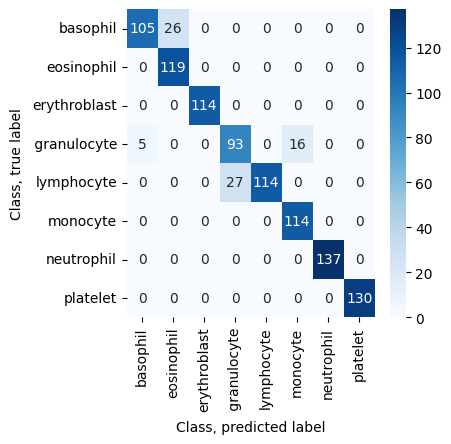

In [8]:
# Poniżej inny wariant macierzy pomyłek
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ocena generatora
from torch.utils.data import TensorDataset, DataLoader

# Zakładam, że generated_samples i generated_labels to tensory
generated_samples = generated_samples.to(device)
generated_labels = generated_labels.to(device).long()

# Tworzenie DataLoadera
gener_dataset = TensorDataset(generated_samples, generated_labels)
gener_loader = DataLoader(gener_dataset, batch_size=128, shuffle=False)

def evaluate_model_with_probabilities_and_confusion_matrix(model, data_loader):
    model.eval()
    total_loss = 0
    correct = 0
    all_probabilities = []  # Lista do przechowywania prawdopodobieństw
    all_labels = []         # Lista do przechowywania etykiet
    all_preds = []          # Lista do przechowywania predykcji

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)  # Obliczanie prawdopodobieństw

            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

            all_probabilities.append(probabilities)
            all_labels.append(labels)
            all_preds.append(outputs.argmax(1))  # Predykcje

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / len(data_loader.dataset)

    # Konkatenacja wyników
    all_probabilities = torch.cat(all_probabilities, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    all_preds = torch.cat(all_preds, dim=0)

    # Obliczanie macierzy pomyłek
    cm = confusion_matrix(all_labels.cpu(), all_preds.cpu())

    return avg_loss, accuracy, all_probabilities, all_labels, cm

test_loss, test_acc, probabilities, labels, cm = evaluate_model_with_probabilities_and_confusion_matrix(model, gener_loader)
print(f'Gener Loss: {test_loss:.4f}, Gener Acc: {test_acc:.4f}')

# Wyświetlanie macierzy pomyłek
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[legend_labels[i][-12:] for i in range(8)], yticklabels=[legend_labels[i][-12:] for i in range(8)])
#plt.title("Confusion Matrix")
plt.xlabel("Class, predicted label")
plt.ylabel("Class, true label")
plt.savefig("ConfusionMartrix02.jpg", dpi=300, bbox_inches='tight')
plt.show()


In [9]:
# FID
#
from torch.utils.data import DataLoader, Subset, TensorDataset, Dataset
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
from PIL import Image
from torchvision.models import inception_v3, Inception_V3_Weights

# Zakładamy, że generated_samples i generated_labels są już zdefiniowane:
# generated_samples: tensor (1000, 3, H, W)
# generated_labels: tensor (1000,)
num_samples = 1000

fid_transform = transforms.Compose([  # Inception V3 wymaga obrazów w rozdzielczości 299x299
    transforms.Resize(299),  # Zmiana rozdzielczości
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalizacja z średnimi z ImageNet
])

class TransformedTensorDataset(Dataset):
    def __init__(self, tensor, labels, transform=None):
        self.tensor = tensor
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.tensor)

    def __getitem__(self, idx):
        img = self.tensor[idx]

        # Jeśli tensor ma 3 wymiary (C, H, W), konwertujemy go na PIL
        if isinstance(img, torch.Tensor):
            img = img.detach().cpu()  # Upewniamy się, że tensor jest na CPU
            if img.dim() == 3:  # (C, H, W)
                img = transforms.ToPILImage()(img)
            elif img.dim() == 2:  # Jeśli grayscale (H, W), dodaj 1 kanał
                img = transforms.ToPILImage()(img.unsqueeze(0))

        # Zastosowanie transformacji (jeśli istnieje)
        if self.transform:
            img = self.transform(img)

        return img, self.labels[idx]

# Stworzenie DataLoader dla wygenerowanych obrazów z transformacją
generated_samples = (generated_samples + 1) / 2.0
gener_dataset = TransformedTensorDataset(generated_samples, generated_labels, transform=fid_transform)
gener_loader = DataLoader(gener_dataset, batch_size=64, shuffle=False)

# Wylosowanie 1000 rzeczywistych obrazów dla całej bazy
train_dataset = BloodMNIST(split='train', transform=fid_transform, download=True, as_rgb=True, size=isize)
all_indices = np.arange(len(train_dataset))  # Tworzy indeksy [0, 1, 2, ..., N-1]
indices = np.random.choice(all_indices, num_samples, replace=False)
real_subset = Subset(train_dataset, indices)
real_loader = DataLoader(real_subset, batch_size=64, shuffle=False)

# Ładowanie modelu Inception V3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Załaduj model Inception v3 z pretrenowanymi wagami
inception_model = inception_v3(weights=Inception_V3_Weights.DEFAULT, aux_logits=True).to(device)
inception_model.eval()

# Funkcja do ekstrakcji cech z modelu Inception V3
def extract_features(loader, model, device):
    model.eval()
    features = []
    
    handle = model.avgpool.register_forward_hook(
        lambda m, i, o: features.append(o.squeeze(-1).squeeze(-1).cpu().numpy())
    )
    with torch.no_grad():
        for batch in loader:
            imgs, _ = batch
            imgs = imgs.to(device)
            _ = model(imgs)  # Wywołanie modelu, aby uruchomić hook
    handle.remove()
    features = np.concatenate(features, axis=0)
    return features

# Funkcja do obliczania FID
def calculate_fid(real_features, gener_features):
    #gener_features = (gener_features + 1) / 2.0 # ???
    #real_features = (real_features + 1) / 2.0 # ???
    mu1 = np.mean(real_features, axis=0)
    mu2 = np.mean(gener_features, axis=0)
    cov1 = np.cov(real_features, rowvar=False) + 1e-6 * np.eye(real_features.shape[1])
    cov2 = np.cov(gener_features, rowvar=False) + 1e-6 * np.eye(gener_features.shape[1])
    diff = mu1 - mu2
    covmean, _ = sqrtm(cov1.dot(cov2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(cov1 + cov2 - 2 * covmean)
    return fid

# Ekstrakcja cech dla całej bazy
real_features = extract_features(real_loader, inception_model, device)
gener_features = extract_features(gener_loader, inception_model, device)

# Obliczenie FID dla całej bazy
fid_all = calculate_fid(real_features, gener_features)
print(f"FID dla całej bazy: {fid_all}")

Using downloaded and verified file: /root/.medmnist/bloodmnist_128.npz
FID dla całej bazy: 48.92283611250508


In [10]:
# Obliczanie FID dla całej klasy
num_classes = 8
num_samples_per_class = 100

# Przechowuj wyniki FID dla każdej klasy
fid_scores = []

num_classes = 8
num_samples_per_class = 100

# Przechowuj wyniki FID dla każdej klasy
fid_scores = []

# Zbieranie rzeczywistych etykiet
real_labels = []
for i in range(len(train_dataset)):
    _, label = train_dataset[i]
    real_labels.append(label.cpu().numpy() if torch.is_tensor(label) else label)  # Obsługa tensorów
real_labels = np.array(real_labels)

# Przeniesienie etykiet do CPU i konwersja na NumPy
gener_labels = generated_labels.cpu().numpy()  #

for class_idx in range(num_classes):
    # Rzeczywiste obrazy
    real_class_indices = np.where(real_labels == class_idx)[0]
    if len(real_class_indices) < num_samples_per_class:
        print(f"Class {class_idx}: za mało rzeczywistych próbek ({len(real_class_indices)}). Pomijam.")
        continue

    real_selected = np.random.choice(real_class_indices, num_samples_per_class, replace=False)
    real_subset = Subset(train_dataset, real_selected)
    real_loader = DataLoader(real_subset, batch_size=64, shuffle=False)

    # Wygenerowane obrazy
    gener_class_indices = np.where(gener_labels == class_idx)[0]  # gener_labels to NumPy
    if len(gener_class_indices) < num_samples_per_class:
        print(f"Class {class_idx}: za mało wygenerowanych próbek ({len(gener_class_indices)}). Pomijam.")
        continue

    gener_selected = np.random.choice(gener_class_indices, num_samples_per_class, replace=False)
    gener_subset = Subset(gener_dataset, gener_selected)
    gener_loader = DataLoader(gener_subset, batch_size=64, shuffle=False)

    # Ekstrakcja cech i FID
    real_features = extract_features(real_loader, inception_model, device)
    gener_features = extract_features(gener_loader, inception_model, device)

    fid = calculate_fid(real_features, gener_features) if (real_features.size > 0 and gener_features.size > 0) else float('inf')
    fid_scores.append(fid)
    print(f"Class {class_idx+1} FID: {fid:.2f}")

print(f"\nŚredni FID: {np.mean(fid_scores):.2f}")

# Zapis do pliku tekstowego
with open("fid_scores.txt", "w") as f:
    for i, score in enumerate(fid_scores):
        f.write(f"FID {i+1}: {score:.2f}\n")
    f.write(f"\nŚredni FID: {np.mean(fid_scores):.2f}\n")
    f.write(f"FID dla całej bazy: {fid_all}")

Class 1 FID: 82.18
Class 2 FID: 92.56
Class 3 FID: 92.54
Class 4 FID: 122.77
Class 5 FID: 97.10
Class 6 FID: 92.83
Class 7 FID: 66.63
Class 8 FID: 127.37

Średni FID: 96.75
